In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/image_retrieval')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt

### Download data

In [0]:
!wget http://www.ee.columbia.edu/~rj2349/index_files/Homework1/Homework1.zip
!unzip Homework1.zip -d data
!rm Homework1.zip

In [0]:
def read_data(folder, grayscale=True):
    '''Read data from the folder

    Parameters
    ----------
    folder: str, the directory with images
    grayscale: bool, apply grayscaling on the RGB or not
    -------
    Returns:
    files: np.ndarray, array with images'''

    # parse images
    files = next(os.walk(folder))[2]
    # open images
    files = np.array(list(map(lambda x: np.array(Image.open(os.path.join(folder, x))), files)))
    # apply or not grayscaling
    if grayscale:
        if len(files.shape) == 4:
            files = np.array(list(map(lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), files)))

    return files

In [7]:
%%time
data = read_data('data')

CPU times: user 18.4 s, sys: 12.2 s, total: 30.6 s
Wall time: 32.3 s


In [8]:
print('The images count - {} items'.format(len(data)))
print('Shape of one image - {}'.format(data[0].shape))
print('The data size - {} Mbytes'.format(data.nbytes // 10**6))

The images count - 2000 items
Shape of one image - (480, 640)
The data size - 614 Mbytes


Task 1

In [0]:
def compute_histogram(image, bins=256):
  
    flat = image.reshape(-1).astype(np.int64)
    bins = np.bincount(flat, minlength=bins)
    
    return bins

Compare two implementations:

In [64]:
%%time
hist_one = compute_histogram(data[0], bins=256)

CPU times: user 2.56 ms, sys: 364 µs, total: 2.92 ms
Wall time: 2.64 ms


In [65]:
%%time
hist_two, _ = np.histogram(data[0], bins=256)

CPU times: user 11.6 ms, sys: 1.7 ms, total: 13.3 ms
Wall time: 17.4 ms


In [51]:
print('Difference between implementations (MSE) - {}'.format(((hist_one - hist_two)**2).mean()))

Difference between implementations (MSE) - 0.0


Compute for all images in the dataset and save as array:

In [68]:
%%time 
histograms = np.array(list(map(compute_histogram, list(data))))

CPU times: user 3.54 s, sys: 5.86 s, total: 9.4 s
Wall time: 9.41 s


In [0]:
histograms = np.array(list(map(lambda x: x / np.linalg.norm(x), list(histograms))))

Task 2

In [0]:
def l2_distance(vector_one, vector_two):
    
    return np.linalg.norm(vector_one - vector_two)**2

In [156]:
l2_distance(histograms[156], histograms[145])

0.599226053657994

Task 3

In [0]:
queries = ['ukbench00004.jpg', 
           'ukbench00040.jpg', 
           'ukbench00060.jpg', 
           'ukbench00588.jpg',
           'ukbench01562.jpg']

ids = [5, 41, 61, 589, 1563]

In [0]:
def query(dataset, query_image, n_neighbors=11, similarity_func=l2_distance):
    
    output_dict = {}
    
    for i in range(len(dataset)):
        output_dict[i] = similarity_func(query_image, dataset[i])
        
    sorted_dict = sorted(output_dict.items(), 
                         key=lambda x: x[1], 
                         reverse=False)
    
    indexes = list(map(lambda x: x[0], sorted_dict[:n_neighbors]))
    
    return indexes

In [0]:
indexes = []

for id in ids:
    
    temporary = query(histograms, histograms[id])
    indexes.append(temporary)
    
indexes = np.array(indexes)

In [162]:
indexes

array([[   5,    8,    6,  868,  560, 1718, 1574,   10,  187,  821, 1575],
       [  41,   44,   42,   43, 1840, 1662, 1911, 1910, 1912, 1489, 1664],
       [  61,   62,  493,  560,  821,  822,  559,  558,  233,  897,  186],
       [ 589,  590,  567,  651,  652,  624,  566, 1845, 1671,  639,  669],
       [1563, 1739,  499, 1602,  498, 1609, 1611, 1731, 1593, 1592, 1647]])

In [0]:
def plot_examples_knn(data, queries, indexes):
    '''Plot the closest data samples 
    to the image from query.
    
    Parameters
    ----------
    data : np.ndarray, 4D tensor with images, full data
    queries: np.ndarray, 4D tensor with query images
    indexes :  np.ndarray, the indexes of the closest objects.
    If query image in the database, it is included in the results.
    '''
    # plot the clusters and its elements in the grid
    nrows = indexes.shape[0]
    ncols = indexes.shape[1]
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10), dpi=150)
    # plot examples
    for i in range(nrows):   
        for j in range(ncols):
            
            picture = data[indexes[i][j]]
            # plot pictures
            axes[i, j].imshow(picture, cmap='gray')
            axes[i, j].axis('off')
            
            if j > 0:
                axes[i, j].set_title('#{y}'.format(y=indexes[i, j]))
            else:
                axes[i, j].set_title('Picture\n{}'.format(indexes[i, 0]))

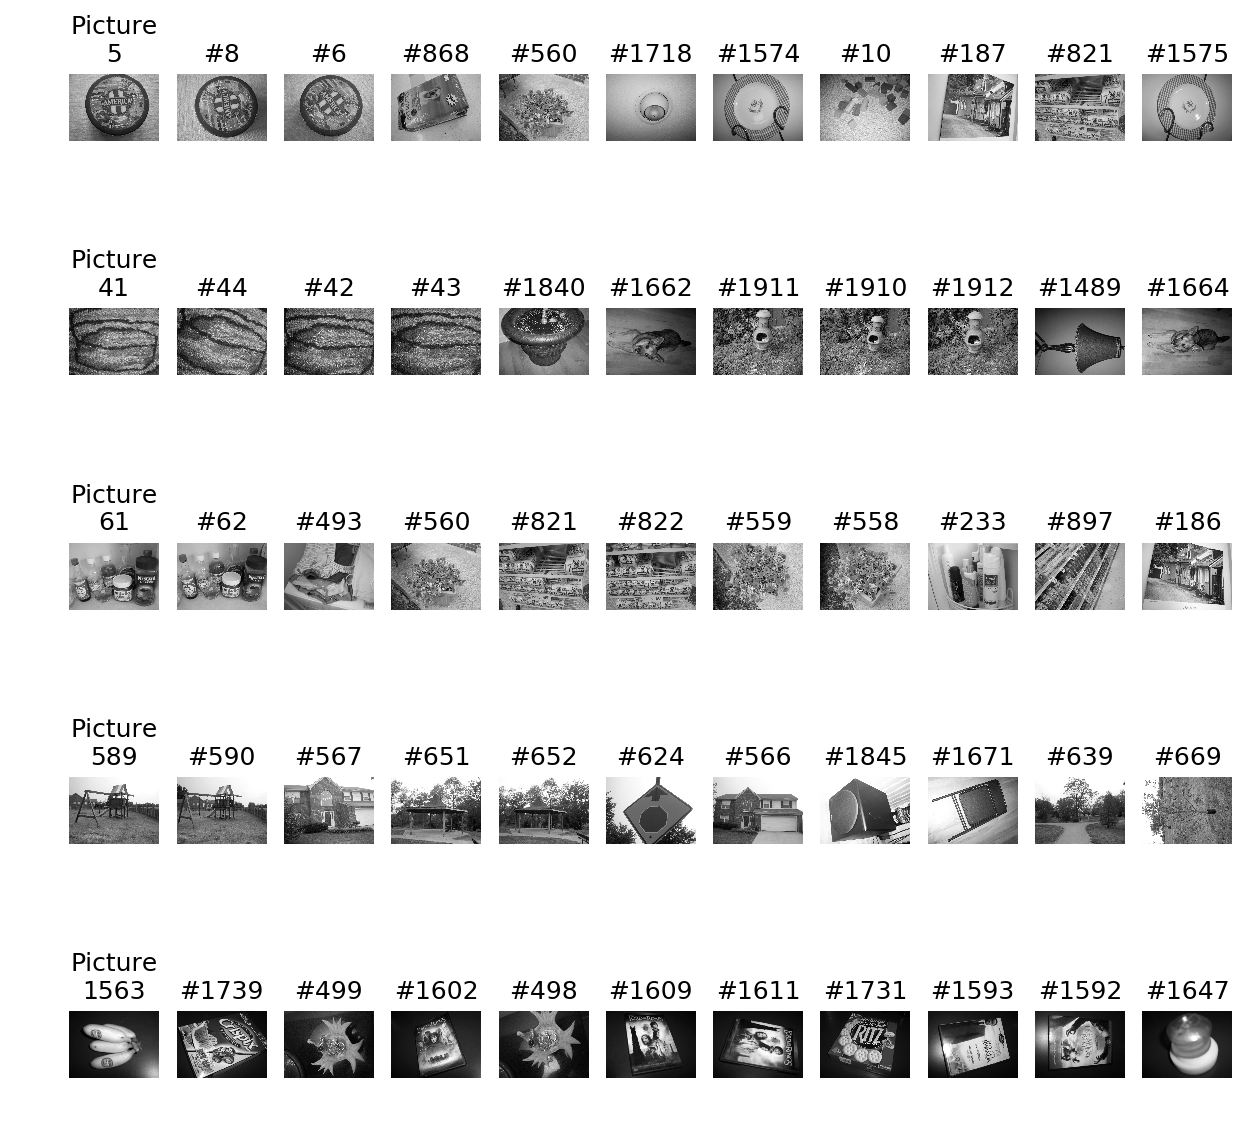

In [164]:
plot_examples_knn(data, data[ids], indexes)

Task 4

In [0]:
def prc(dataset, query_image, n_neighbors, similarity_func):
  
    #thresholds = np.arange(0, 1.05, 0.05)
    thresholds = [0.5]
    
    points = []
    
    for th in thresholds:
    
        output_dict = {}
    
        for i in range(len(dataset)):
            output_dict[i] = similarity_func(query_image, dataset[i])
        
        sorted_dict = sorted(output_dict.items(), 
                             key=lambda x: x[1], 
                             reverse=True)
   
        values_all = np.array(list(map(lambda x: x[1], sorted_dict))) / 4.0
        values_top = np.array(values_all[:n_neighbors]) / 4.0
      
        precision = (values_top > th).astype(float).sum() / len(values_top)
        recall = (values_top > th).astype(float).sum() / (values_all > th).astype(float).sum()
        
        points.append([precision, recall])
        
    return points

In [169]:
l = prc(histograms, histograms[4], 11, l2_distance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [170]:
l

[[0.0, nan]]